In [15]:
import pandas as pd 
import seaborn as sns
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['Variable',"Valeurs Manquantes"]
    statitics['Nombre de lignes'] = df.shape[0]
    statitics['% Manquant'] = round((statitics['Valeurs Manquantes']/statitics['Nombre de lignes'])*100,2)
    return statitics

In [6]:
data = pd.read_csv("hour.csv")

In [10]:
data.head

<bound method NDFrame.head of        instant      dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  2011-01-01       1   0     1   0        0        6   
1            2  2011-01-01       1   0     1   1        0        6   
2            3  2011-01-01       1   0     1   2        0        6   
3            4  2011-01-01       1   0     1   3        0        6   
4            5  2011-01-01       1   0     1   4        0        6   
5            6  2011-01-01       1   0     1   5        0        6   
6            7  2011-01-01       1   0     1   6        0        6   
7            8  2011-01-01       1   0     1   7        0        6   
8            9  2011-01-01       1   0     1   8        0        6   
9           10  2011-01-01       1   0     1   9        0        6   
10          11  2011-01-01       1   0     1  10        0        6   
11          12  2011-01-01       1   0     1  11        0        6   
12          13  2011-01-01       1   0     1  12        0   

In [8]:
missing_statistics(data)

,Variable,Valeurs Manquantes,Nombre de lignes,% Manquant
0,instant,0,17379,0.0
1,dteday,0,17379,0.0
2,season,0,17379,0.0
3,yr,0,17379,0.0
4,mnth,0,17379,0.0
5,hr,0,17379,0.0
6,holiday,0,17379,0.0
7,weekday,0,17379,0.0
8,workingday,0,17379,0.0
9,weathersit,0,17379,0.0


Il n'y a pas de données manquantes dans la base.

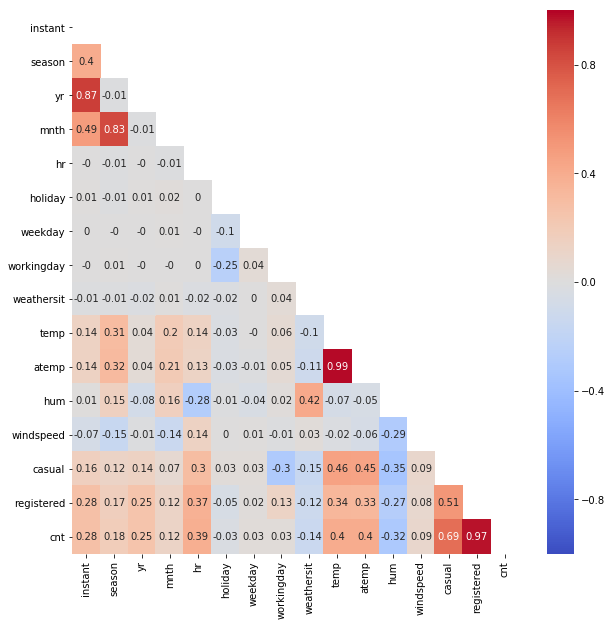

In [16]:
##############
#### Matrice de corrélation
#### Nos varaibles ne sont pas très fortement corrélé
##############


corr= data.drop(columns=["dteday"]).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr.round(2), mask=mask,
            vmin=-1,     
            cmap='coolwarm',
            annot=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


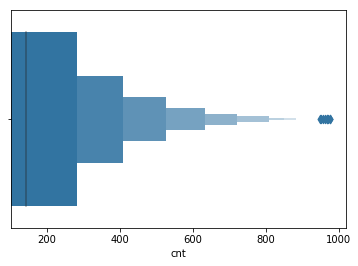

In [21]:
sns.boxenplot(data["cnt"])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

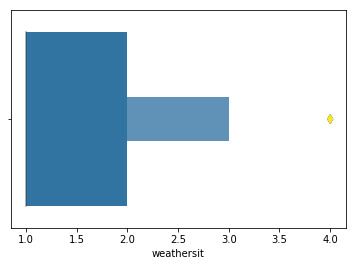

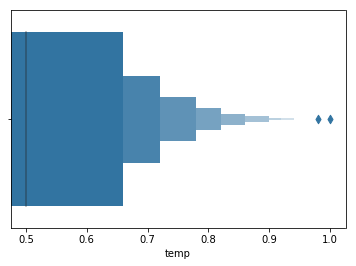

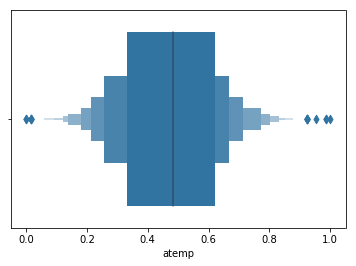

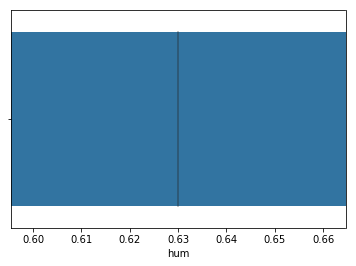

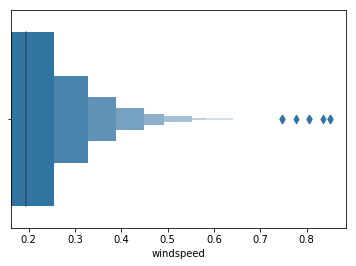

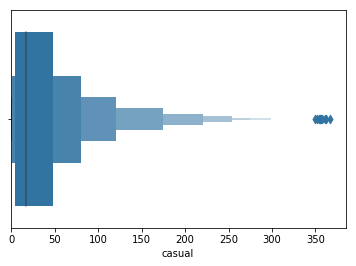

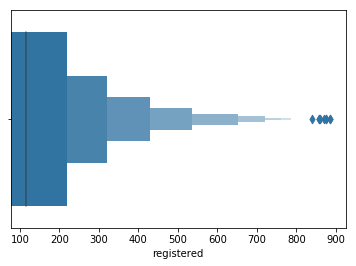

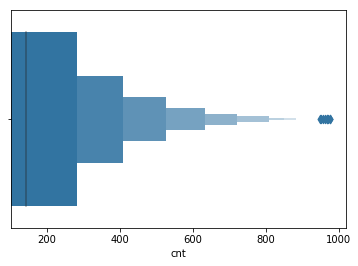

In [27]:
columns = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']
for i, col in enumerate(columns):
    plt.figure(i)
    sns.boxenplot(data[col])